In [4]:
# Notebook Imports
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import string
from collections import defaultdict
from sklearn.metrics import r2_score
import statsmodels.api as sm
%matplotlib inline

conn = psycopg2.connect(dbname="illinois_gambling")

def query(query):
    return pd.read_sql(query, conn)

## Introduction

Video gambling was legalized by the state of Illinois in 2009, with the first machines activated in September of 2012. Since then the number of towns that have installed video gambling machines has increased every year. 

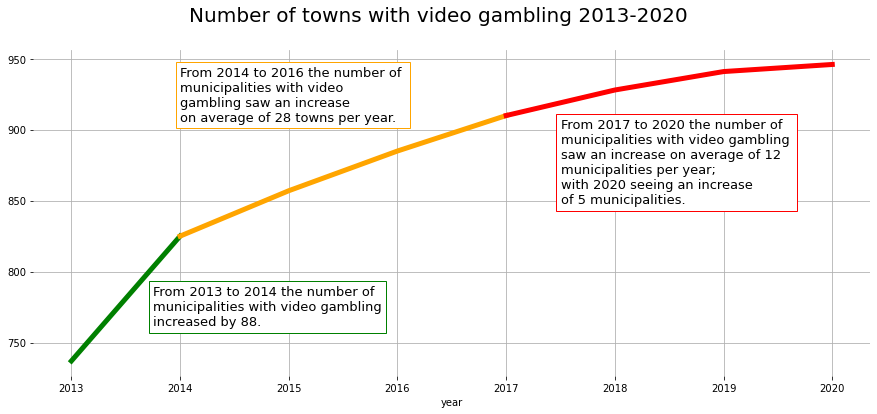

In [6]:
q = '''SELECT DISTINCT CAST(date_part('year', video_gambling.date) AS INT) as year, 
              count(DISTINCT municipality.name) as num_of_towns
       FROM municipality
       INNER JOIN video_gambling
       ON municipality.name = video_gambling.municipality
       GROUP BY date_part('year', video_gambling.date);'''

query_results = query(q).set_index('year')
fig, ax = plt.subplots()
query_results.loc[:2014].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='green')
query_results.loc[2014:2017].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='orange')
query_results.loc[2017:].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='red')
# axes[0].set_yticks(query_results.num_of_towns)
fig.suptitle('Number of towns with video gambling 2013-2020', fontsize=20)
ax.grid()

ax.set_frame_on(False)

first_annotation = ax.text(2013.75, 762, 
f'''From 2013 to 2014 the number of\nmunicipalities \
with video gambling\nincreased by\
 {int(query_results.loc[[2013,2014]].num_of_towns.diff().iloc[1])}.''', dict(size=13))
first_annotation.set_bbox(dict(facecolor='white', edgecolor='green'))

second_annotation = ax.text(2014, 906, f'''\
From 2014 to 2016 the number of 
municipalities with video 
gambling saw an increase\non average of \
{int(round(query_results.loc[2014:2017].num_of_towns.diff().mean()))} \
towns per year.''', dict(size=13))
second_annotation.set_bbox(dict(facecolor='white', edgecolor='orange'))

third_annotation = ax.text(2017.5, 848, f'''\
From 2017 to 2020 the number of
municipalities with video gambling 
saw an increase on average of \
{int(round(query_results.loc[2017:].num_of_towns.diff().mean()))} 
municipalities per year; 
with 2020 seeing an increase 
of {int(round(query_results.loc[2017:].num_of_towns.diff().loc[2020]))} municipalities.''', dict(size=13))
third_annotation.set_bbox(dict(facecolor='white', edgecolor='red'))


## Outline

- Video gambling growth
    - ~~Increase of towns~~
    - Increase of gambling devices
    - Increase of amount played
    - Change in revenue for state and local governments
    - Amount returns to owner
    
- Casino growth
    - Increase in casinos
    - Increase in adjusted gross receipt
    - Increase in local and state shares
    
- Breakdown of tax rates
    - Visualization of the difference in the distribution between the vg and casino tax rates
    
- Analysis of the correlation between amount played and AGR.
    
- Analysis of casino loss 
    - Description of the data that has been collected
    - Description of how municipalities were clustered according to the nearest casino
    - Analysis of the statistical likelyhood of having a tax rate > 30%
        - Check the year frequency within the population of tax rates that fell above 30%
    - Modeling the data with MLM
        - Baseline: AGR ~ amount_played_centered
        - Bring in industry variables
        - Bring in demographic variables

In [83]:
q = '''SELECT DISTINCT municipality
        FROM casino;'''

towns_with_casinos = query(q)

q = '''SELECT DISTINCT town.name
        FROM municipality town
        LEFT JOIN casino ON casino.municipality = town.name
        WHERE casino.municipality IS NULL'''
towns_without_casinos = query(q)

q = '''SELECT * from demographics_lookup'''

lookup = query(q)

demographic_variables = ('demo.' + '"' +  lookup['variable'] + '"').to_list()

q = f'''SELECT {", ".join(demographic_variables)},
              video.terminal_count,
              video.date,
              video.state_share as video_state_share,
              video.municipality_share as video_local_share,
              video.amount_played,
              town.name,
              town.nearest_casino,
              casino.adjusted_gross_receipt,
              casino.state_share as casino_state_share,
              casino.local_share as casino_local_share
      FROM demographics demo
      JOIN municipality town
          ON demo.municipality = town.name
          AND demo.geo_id = town.geo_id
     JOIN casino
          ON casino.address = town.nearest_casino
     JOIN video_gambling video
          ON video.municipality = town.name
     WHERE date_part('year', video.date) = demo.year
     AND casino.date = video.date
     ORDER BY date;'''


q = """SELECT terminal_count, 
              amount_played,
              town.name
              nearest_casino,
              video_state_share,
              video_local_share,
              casino.state_share AS casino_state_share,
              casino.local_share AS casino_local_share,
              date,
              adjusted_gross_receipt,
              FROM (
                      SELECT SUM(terminal_count), SUM(amount_played,)
                             SUM(municipality_share) AS video_local_share,
                             SUM(state_share) AS video_state_share,
                             name,
                             FROM video_gambling
                             GROUP BY DATE_PART('year', 'date'), 
                                      DATE_PART('month', 'date'), 
                                      town.nearest_casino)
                             INNER JOIN municipality town
                             ON video_gamling.municipality = municipality.name ) subquery
            INNER JOIN casino
            ON subquery.name = casino.municipality;
              """

df = query(q)

In [ ]:
q = """SELECT terminal_count, 
              amount_played,
              town.name
              nearest_casino,
              video_state_share,
              video_local_share,
              casino.state_share AS casino_state_share,
              casino.local_share AS casino_local_share,
              date,
              adjusted_gross_receipt
              FROM (
                      SELECT SUM(terminal_count), SUM(amount_played),
                             SUM(municipality_share) AS video_local_share,
                             SUM(state_share) AS video_state_share
                             FROM video_gambling
                             INNER JOIN municipality town
                             ON video_gambling.municipality = town.name
                             GROUP BY DATE_PART('year', video_gambling.date), 
                                      DATE_PART('month', video_gambling.date), 
                                      town.nearest_casino) AS subquery
            INNER JOIN casino
            ON subquery.name = casino.municipality;
              """



"""SELECT SUM(amount_played),
          SUM(terminal_count),
          SUM(municipality_share) AS video_local

In [61]:
q = '''SELECT * from demographics_lookup'''

lookup = query(q)

demographic_variables = ('demo.' + '"' +  lookup['variable'] + '"').to_list()

# q = f"""SELECT town.nearest_casino,

#               CAST(CAST(DATE_PART('YEAR',casino.date) AS INTEGER) AS TEXT) AS year,
              
#               SUM(casino.adjusted_gross_receipt) AS agr,
#               SUM(video.amount_played) AS amount_played,
#               SUM(terminal_count) AS terminal_count,
#               SUM(video.municipality_share) AS video_local_share,
#               SUM(video.state_share) as video_state_share,
#               SUM(casino.local_share) as casino_local_share,
#               SUM(casino.state_share) as casino_state_share,
#               {", ".join(f"SUM({demo} ) AS {demo.replace('demo.', '')}" for demo in demographic_variables)}
#               FROM video_gambling video
#               INNER JOIN municipality town
#               ON video.municipality = town.name
#               INNER JOIN demographics demo
#               ON town.name = demo.municipality 
#               INNER JOIN casino
#               ON town.name = casino.municipality AND video.date = casino.date
#               GROUP BY town.nearest_casino, DATE_PART('YEAR', casino.date);"""

# df = query(q)


# q = f"""SELECT town.name,
#                SUM(video.terminal_count),
#                SUM(video.amount_played),
#                SUM(video.municipality_share) AS video_local_share,
#                SUM(video.state_share) AS video_state_share,
#                SUM(casino.adjusted_gross_receipt) AS agr,
#                SUM(casino.state_share) AS casino_state_share,
#                SUM(casino.local_share) AS casino_local_share,
#                {", ".join(f"SUM({demo} ) AS {demo.replace('demo.', '')}" for demo in demographic_variables)},
#                demo.year
#                FROM municipality town
#                INNER JOIN video_gambling video
#                ON town.name = video.municipality
#                INNER JOIN casino
#                ON video.municipality = casino.municipality
#                INNER JOIN demographics demo
#                ON casino.municipality = demo.municipality
#                GROUP BY town.name, demo.year
#                ;"""

video = """SELECT CONCAT(
                      CAST(CAST(DATE_PART('YEAR', video.date) AS INTEGER) AS TEXT),
                      '-',
                      CAST(CAST(DATE_PART('MONTH', video.date) AS INTEGER) AS TEXT)) AS date,
              video.municipality,
              SUM(video.terminal_count) AS terminal_count,
              SUM(video.amount_played) - SUM(video.amount_won) AS video_agr,
              SUM(video.municipality_share) AS video_local_share, 
              SUM(video.state_share) AS video_state_share
              FROM video_gambling video
              WHERE video.municipality IN (
              SELECT casino.municipality
              FROM casino)
              GROUP BY video.municipality, 
                       DATE_PART('YEAR', video.date), 
                       DATE_PART('MONTH', video.date)"""

casino = '''SELECT CONCAT(
                      CAST(CAST(DATE_PART('YEAR', casino.date) AS INTEGER) AS TEXT),
                      '-',
                      CAST(CAST(DATE_PART('MONTH', casino.date) AS INTEGER) AS TEXT)) AS date,
                   SUM(casino.adjusted_gross_receipt) AS casino_agr,
                   SUM(casino.admissions) AS admissions,
                   SUM(casino.state_share) AS casino_state_share,
                   SUM(casino.local_share) AS casino_local_share,
                   casino.municipality
                   FROM casino
                   GROUP BY casino.municipality, DATE_PART('YEAR', casino.date), DATE_PART('MONTH', casino.date);'''

yearly_demographics = f'''SELECT demo.year,
                        demo.municipality,
                        SUM(demo."B01003_001E") as population
                        FROM demographics demo
                        GROUP BY demo.year, demo.municipality'''

video_demographics = f"""SELECT demo."B01003_001E"as population,
                                demo.year,
                                demo.municipality 
                         FROM demographics demo
                   WHERE demo.year IN (
                   SELECT DATE_PART('year', video.date) as year
                   FROM video_gambling video) 
                   AND demo.municipality IN (
                   SELECT DISTINCT municipality FROM casino);"""

df = query(video).merge(query(casino), on=['municipality', 'date'])
demographics = query(yearly_demographics)

In [62]:
df['casino_public_funds'] = df.casino_local_share + df.casino_state_share
df['video_public_funds'] = df.video_local_share + df.video_state_share
df.date = pd.to_datetime(df.date, format='%Y-%m')
df.set_index('date', inplace=True)
df = df.loc[:'2019']
yearly = df.groupby([pd.Grouper(freq='Y'), 'municipality']).sum().reset_index().set_index('date')
yearly['year'] = [date.year for date in yearly.index]
yearly = yearly.merge(demographics, on=['year', 'municipality'], right_index=True)
df['year'] = [x.year for x in df.index]
df = df.merge(query(video_demographics), on=['municipality', 'year'], right_index=True)

In [69]:
df[df.population == df.population.min()]

,municipality,terminal_count,video_agr,video_local_share,video_state_share,casino_agr,admissions,casino_state_share,casino_local_share,casino_public_funds,video_public_funds,year,population
date,,,,,,,,,,,,,
2018-01-01,Metropolis,82.0,385602.20,19277.34,96386.88,4766126.0,32532.0,541677.0,270838.0,812515.0,115664.22,2018,6184
2018-02-01,Metropolis,82.0,502799.54,25180.58,125903.16,5434248.0,34918.0,613261.0,306630.0,919891.0,151083.74,2018,6184
2018-03-01,Metropolis,82.0,675993.82,33799.22,168996.18,4278723.0,25957.0,479786.0,239893.0,719679.0,202795.40,2018,6184
2018-04-01,Metropolis,82.0,507078.96,25312.84,126564.34,6481966.0,41958.0,732113.0,366056.0,1098169.0,151877.18,2018,6184
2018-05-01,Metropolis,82.0,533282.72,26711.50,133557.54,6053909.0,41435.0,839384.0,344130.0,1183514.0,160269.04,2018,6184
2018-06-01,Metropolis,82.0,529229.68,26414.12,132070.58,6813199.0,44539.0,1281388.0,385199.0,1666587.0,158484.70,2018,6184
2018-07-01,Metropolis,88.0,461999.08,23117.68,115588.80,6514508.0,45330.0,1230699.0,371055.0,1601754.0,138706.48,2018,6184
2018-08-01,Metropolis,88.0,509387.02,25459.80,127299.32,6414233.0,42641.0,1207773.0,363353.0,1571126.0,152759.12,2018,6184
2018-09-01,Metropolis,88.0,453664.94,22745.70,113728.88,6308442.0,42661.0,1342567.0,358083.0,1700650.0,136474.58,2018,6184


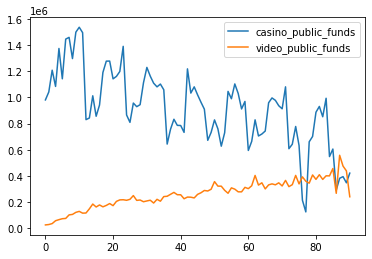

In [28]:
df[df.municipality == df.municipality.unique()[0]][['casino_public_funds', 'video_public_funds']].plot()

Let's collect the column descriptions from the `lookup` table and replace the variable names that are currently being used as column names. 

In [10]:
variable_map = lookup.drop('index', axis = 1).set_index('variable').to_dict('index')

def variable_rename(column):
    translator=str.maketrans('','',string.punctuation)
    if column  in variable_map:
        return variable_map[column]['description'].lower().strip().translate(translator).replace(' ', '_')
    else:
        return column

yearly.columns = [variable_rename(column) for column in yearly.columns]

In [2]:
lookup

NameError: name 'lookup' is not defined

In [168]:
yearly[['municipality', 'terminal_count', 'video_agr', 'video_local_share',
       'video_state_share', 'casino_agr', 'admissions', 'casino_state_share',
       'casino_local_share', 'casino_public_funds', 'video_public_funds',
       'video_public_cent', 'casino_public_cent', 'year',
       'total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing', 'total_wholesale_trade',
       'total_retail_trade',
       'total_transportation_and_warehousing_and_utilities',
       'total_information',
       'total_finance_and_insurance_and_real_estate_and_rental_and_leasing',
       'total_professional_scientific_and_management_and_administrative_and_waste_management_services',
       'total_educational_services_and_health_care_and_social_assistance',
       'total_arts_entertainment_and_recreation_and_accommodation_and_food_services',
       'total_other_services_except_public_administration',
       'total_public_administration',
       'total_management_business_science_and_arts_occupations',
       'total_service_occupations', 'total_sales_and_office_occupations',
       'total_natural_resources_construction_and_maintenance_occupations',
       'total_production_transportation_and_material_moving_occupations',
       'population_of_one_race_white',
       'population_of_one_race_black_or_african_american',
       'population_of_one_race_american_indian_and_alaska_native',
       'population_of_one_race_asian_alone',
       'population_of_one_race_native_hawaiian_and_other_pacific_islander',
       'population_of_one_race_some_other_race', 'median_age_total',
       'educational_attainment_for_the_population_25_years_and_over',
       'median_income_in_the_past_12_months_in_prior_year_inflationadjusted_dollarstotal_dollars',
       'total_population_estimatetotal']]

Index(['municipality', 'terminal_count', 'video_agr', 'video_local_share',
       'video_state_share', 'casino_agr', 'admissions', 'casino_state_share',
       'casino_local_share', 'casino_public_funds', 'video_public_funds',
       'video_public_cent', 'casino_public_cent', 'year',
       'total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing', 'total_wholesale_trade',
       'total_retail_trade',
       'total_transportation_and_warehousing_and_utilities',
       'total_information',
       'total_finance_and_insurance_and_real_estate_and_rental_and_leasing',
       'total_professional_scientific_and_management_and_administrative_and_waste_management_services',
       'total_educational_services_and_health_care_and_social_assistance',
       'total_arts_entertainment_and_recreation_and_accommodation_and_food_services',
       'total_other_services_except_public_administration',
       'total_public_administration',
       'tota

In [98]:
len(df.municipality.unique())

7

NameError: name 'subplot_map' is not defined

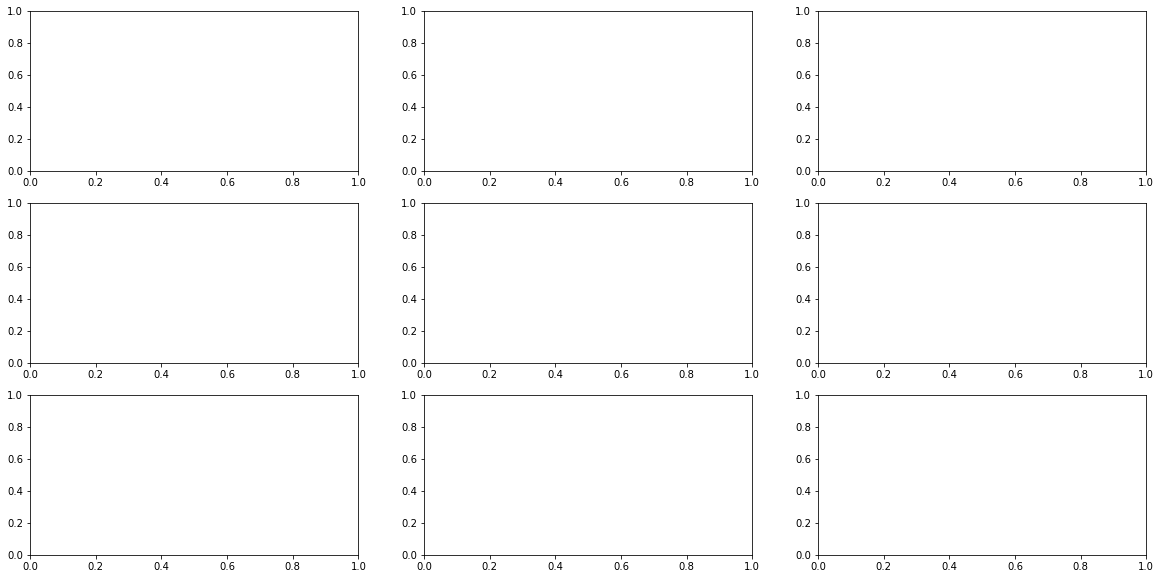

In [11]:
figure, axes = plt.subplots(3,3, figsize=(20,10))
casinos = df.municipality.unique()
for idx in range(len(casinos)):
    frame = df[df.municipality == casinos[idx]][['casino_public_funds', 'video_public_funds']]
    row, column = subplot_map(idx, 3)
    frame.plot(ax=axes[row,column], title=casinos[idx])
figure.tight_layout()

In [ ]:
df.amount_played - df.amount

In [132]:
df.set

,date,municipality,terminal_count,video_agr,video_local_share,video_state_share,casino_agr,admissions,casino_state_share,casino_local_share,casino_public_funds,video_public_funds
0,2013-1,Alton,28.0,89280.52,4464.08,22320.40,5283000.00,63037.0,654000.00,327000.00,981000.00,26784.48
1,2013-2,Alton,38.0,98998.30,4949.90,24749.26,5640702.00,65222.0,694514.00,347257.00,1041771.00,29699.16
2,2013-3,Alton,64.0,123117.68,6162.90,30772.72,6618381.00,71683.0,805204.00,402602.00,1207806.00,36935.62
3,2013-4,Alton,82.0,196128.58,9806.54,49032.48,5937582.00,64442.0,722642.00,361321.00,1083963.00,58839.02
4,2013-5,Alton,96.0,223333.28,11166.58,55833.16,5727268.00,66369.0,1020979.00,352732.00,1373711.00,66999.74
...,...,...,...,...,...,...,...,...,...,...,...,...
624,2020-3,Rock Island,186.0,388774.04,19438.58,108856.30,2250709.00,32228.0,257299.00,144763.00,402062.00,128294.88
625,2020-7,Rock Island,184.0,658124.66,32906.58,190858.10,2731834.85,24474.0,297657.48,161065.77,458723.25,223764.68
626,2020-8,Rock Island,184.0,661797.58,33089.74,191920.42,2837592.16,32848.0,316607.24,174727.62,491334.86,225010.16
627,2020-9,Rock Island,198.0,648268.72,32413.60,187998.70,2912185.18,29117.0,320335.50,174726.28,495061.78,220412.30


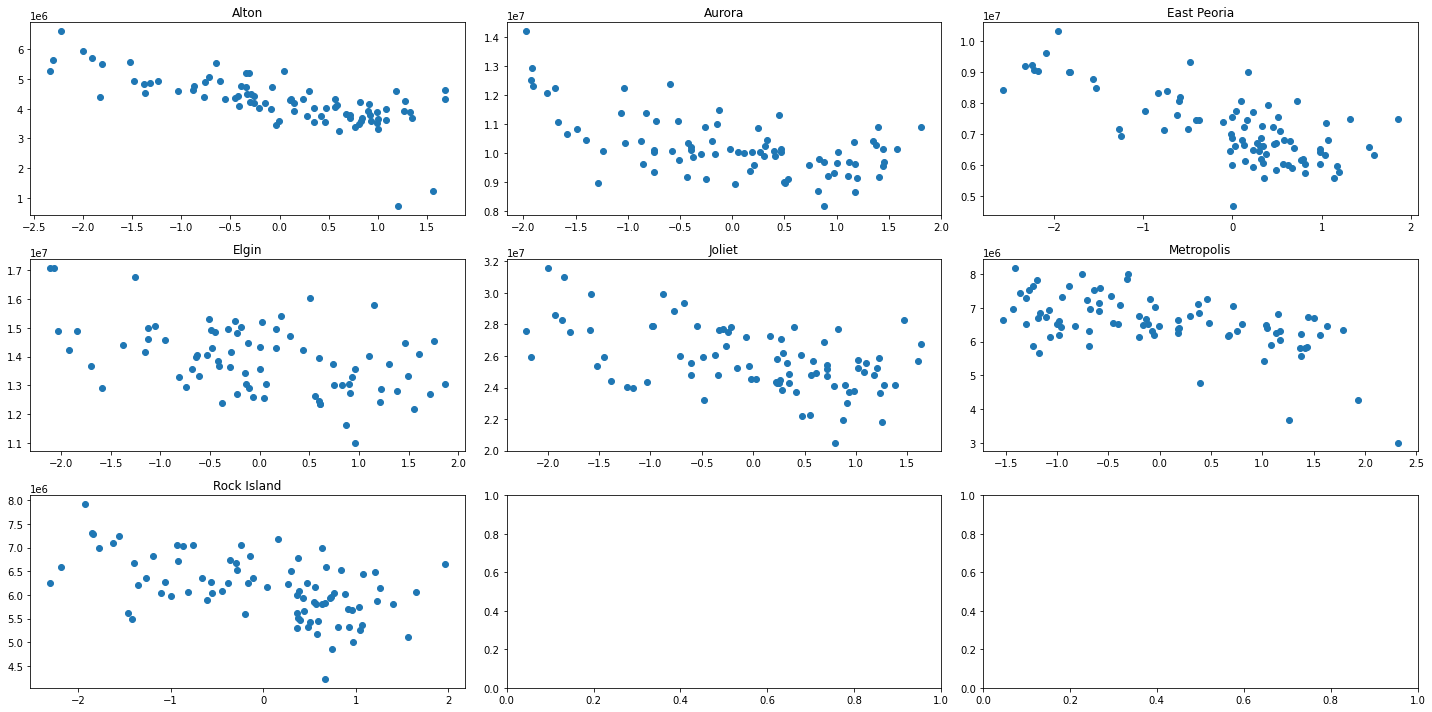

In [179]:
import seaborn as sns
figure, axes = plt.subplots(3,3, figsize=(20,10))
casinos = df.municipality.unique()
for idx in range(len(casinos)):
    frame = df[df.municipality == casinos[idx]][['casino_agr', 'video_agr']]
    row, column = subplot_map(idx, 3)
#     frame.plot(ax=axes[row,column], title=casinos[idx])
    axes[row,column].scatter(frame.video_agr, frame.casino_agr)
    axes[row,column].set_title(casinos[idx])
figure.tight_layout()

NameError: name 'yearly' is not defined

In [12]:
model = sm.OLS(df.casino_public_funds, df.terminal_count).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     casino_public_funds   R-squared (uncentered):                   0.760
Model:                             OLS   Adj. R-squared (uncentered):              0.759
Method:                  Least Squares   F-statistic:                              1831.
Date:                 Tue, 22 Dec 2020   Prob (F-statistic):                   1.91e-181
Time:                         10:08:44   Log-Likelihood:                         -9240.5
No. Observations:                  580   AIC:                                  1.848e+04
Df Residuals:                      579   BIC:                                  1.849e+04
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
terminal_count  1.292e+04    301.966     42.790      0.000    1.23e+04    1.35e+04
==============================================================================
Omnibus:                       80.583   Durbin-Watson:                   0.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.884
Skew:                           0.859   Prob(JB):                     1.14e-30
Kurtosis:                       4.660   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

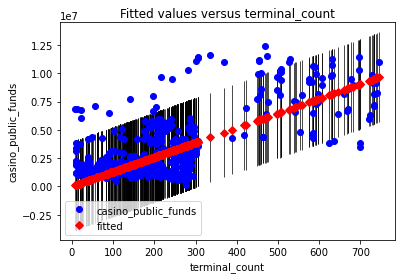

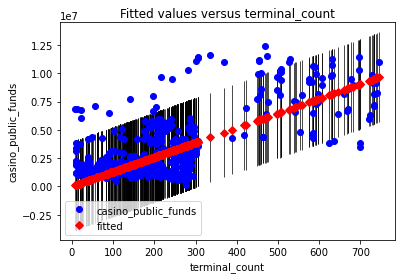

In [13]:
sm.graphics.plot_fit(model, 0)

In [ ]:
x.

In [14]:
df['video_agr'] = df\
                            .groupby("municipality")["video_agr"]\
                            .transform(lambda x: (x - x.mean())/x.std())

df['video_public_cent'] = df\
                            .groupby("municipality")["video_public_funds"]\
                            .transform(lambda x: (x - x.mean())/x.std())

df['casino_public_cent'] = df\
                            .groupby("municipality")["casino_public_funds"]\
                            .transform(lambda x: (x - x.mean())/x.std())
                                                
    
    
df['terminal_count_cent'] = df\
                            .groupby("municipality")["terminal_count"]\
                            .transform(lambda x: (x - x.mean())/x.std())

In [16]:
model = sm.OLS(df.casino_public_funds, sm.add_constant(df.terminal_count)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     casino_public_funds   R-squared:                       0.448
Model:                             OLS   Adj. R-squared:                  0.447
Method:                  Least Squares   F-statistic:                     469.1
Date:                 Tue, 22 Dec 2020   Prob (F-statistic):           1.30e-76
Time:                         10:09:12   Log-Likelihood:                -9229.9
No. Observations:                  580   AIC:                         1.846e+04
Df Residuals:                      578   BIC:                         1.847e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.498e+05   1.41e+05      4.623      0.000    3.74e+05    9.26e+05
terminal_count  1.101e+04    508.454     21.659      0.000       1e+04     1.2e+04
==============================================================================
Omnibus:                      105.681   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.124
Skew:                           1.067   Prob(JB):                     3.15e-42
Kurtosis:                       4.832   Cond. No.                         474.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

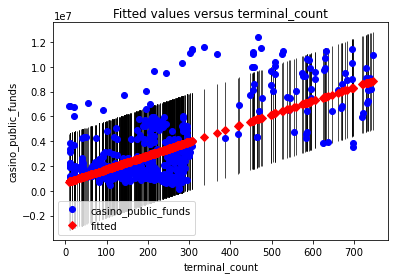

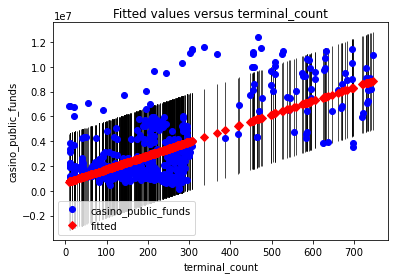

In [17]:
sm.graphics.plot_fit(model, 1)

In [20]:
model = sm.MixedLM.from_formula('casino_public_funds ~ terminal_count', 
                        groups='municipality',
                        re_formula = '1 + ',
                        data=df)

results = model.fit()
results.summary()                                                

/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Mixed Linear Model Regression Results
====================================================================================================
Model:                         MixedLM            Dependent Variable:            casino_public_funds
No. Observations:              580                Method:                        REML               
No. Groups:                    7                  Scale:                         1157475351283.2952 
Min. group size:               78                 Log-Likelihood:                -8910.1447         
Max. group size:               84                 Converged:                     Yes                
Mean group size:               82.9                                                                 
----------------------------------------------------------------------------------------------------
                                        Coef.         Std.Err.    z    P>|z|    [0.025      0.975]  
----------------------------------------------------------------------------------------------------
Intercept                               3817005.590 1016921.643  3.753 0.000 1823875.794 5810135.387
terminal_count                            -3640.368  198849.813 -0.018 0.985 -393378.839  386098.103
municipality Var                  7057157846507.326 3732227.971                                     
municipality x terminal_count Cov   -2163682739.845 2465767.383                                     
terminal_count Var                 276782123791.172                                                 
====================================================================================================

"""

In [224]:
industry_variables = ['total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing', 'total_wholesale_trade',
       'total_retail_trade',
       'total_transportation_and_warehousing_and_utilities',
       'total_information',
       'total_finance_and_insurance_and_real_estate_and_rental_and_leasing',
       'total_professional_scientific_and_management_and_administrative_and_waste_management_services',
       'total_educational_services_and_health_care_and_social_assistance',
       'total_arts_entertainment_and_recreation_and_accommodation_and_food_services',
       'total_other_services_except_public_administration',
       'total_public_administration',
       'total_management_business_science_and_arts_occupations',
       'total_service_occupations', 'total_sales_and_office_occupations',
       'total_natural_resources_construction_and_maintenance_occupations',
       'total_production_transportation_and_material_moving_occupations']

In [230]:
yearly.head()

,municipality,terminal_count,video_agr,video_local_share,video_state_share,casino_agr,admissions,casino_state_share,casino_local_share,casino_public_funds,...,population_of_one_race_white,population_of_one_race_black_or_african_american,population_of_one_race_american_indian_and_alaska_native,population_of_one_race_asian_alone,population_of_one_race_native_hawaiian_and_other_pacific_islander,population_of_one_race_some_other_race,median_age_total,educational_attainment_for_the_population_25_years_and_over,median_income_in_the_past_12_months_in_prior_year_inflationadjusted_dollarstotal_dollars,total_population_estimatetotal
date,,,,,,,,,,,,,,,,,,,,,
2013-12-31,Alton,1230.0,-21.341270,158249.04,791204.50,64271362.0,753296.0,11592264.0,3966677.0,15558941.0,...,19555.0,6687.0,143.0,193.0,0.0,52.0,34.4,18349.0,21832.0,27635.0
2013-12-31,Aurora,504.0,-17.335664,72899.52,364498.08,119333859.0,1056003.0,32841631.0,7022696.0,39864327.0,...,109939.0,18920.0,647.0,14597.0,67.0,47849.0,31.5,119047.0,27944.0,198726.0
2013-12-31,East Peoria,1094.0,-23.600722,135530.00,677650.66,107304114.0,1094140.0,23937631.0,6459052.0,30396683.0,...,22095.0,206.0,12.0,360.0,0.0,39.0,40.3,16431.0,27382.0,23252.0
2013-12-31,Elgin,210.0,-11.679826,19545.16,97725.90,91902494.0,774289.0,34741309.0,5369414.0,40110723.0,...,72234.0,6936.0,400.0,6201.0,9.0,21313.0,32.7,67391.0,26580.0,109825.0
2013-12-31,Joliet,2922.0,-21.303668,339430.54,1697154.10,333728342.0,2896733.0,92058126.0,19583109.0,111641235.0,...,103736.0,22425.0,322.0,3543.0,11.0,13576.0,32.4,89594.0,27792.0,147459.0


In [246]:
yearly_percapita = yearly[industry_variables].div(yearly.total_population_estimatetotal, axis=0)
yearly_percapita['municipality'] = yearly.municipality
largest_industries = {}
for town in yearly.municipality.unique(): 
    table = yearly_percapita[yearly_percapita.municipality == town]

    largest_industry = {}
    for idx in table.index:
        industry = table.iloc[0].drop('municipality').sort_values(ascending=False).index[0]
        largest_industry[idx] = industry
    largest_industries[town] = largest_industry

In [249]:
yearly['largest_industry'] = ''
for idx, row in yearly.iterrows():
    industry = largest_industries[row.municipality][idx]
    yearly.at[idx, 'largest_industry'] = industry

In [251]:
yearly.head()

,municipality,terminal_count,video_agr,video_local_share,video_state_share,casino_agr,admissions,casino_state_share,casino_local_share,casino_public_funds,...,population_of_one_race_black_or_african_american,population_of_one_race_american_indian_and_alaska_native,population_of_one_race_asian_alone,population_of_one_race_native_hawaiian_and_other_pacific_islander,population_of_one_race_some_other_race,median_age_total,educational_attainment_for_the_population_25_years_and_over,median_income_in_the_past_12_months_in_prior_year_inflationadjusted_dollarstotal_dollars,total_population_estimatetotal,largest_industry
date,,,,,,,,,,,,,,,,,,,,,
2013-12-31,Alton,1230.0,-21.341270,158249.04,791204.50,64271362.0,753296.0,11592264.0,3966677.0,15558941.0,...,6687.0,143.0,193.0,0.0,52.0,34.4,18349.0,21832.0,27635.0,total_management_business_science_and_arts_occ...
2013-12-31,Aurora,504.0,-17.335664,72899.52,364498.08,119333859.0,1056003.0,32841631.0,7022696.0,39864327.0,...,18920.0,647.0,14597.0,67.0,47849.0,31.5,119047.0,27944.0,198726.0,total_management_business_science_and_arts_occ...
2013-12-31,East Peoria,1094.0,-23.600722,135530.00,677650.66,107304114.0,1094140.0,23937631.0,6459052.0,30396683.0,...,206.0,12.0,360.0,0.0,39.0,40.3,16431.0,27382.0,23252.0,total_management_business_science_and_arts_occ...
2013-12-31,Elgin,210.0,-11.679826,19545.16,97725.90,91902494.0,774289.0,34741309.0,5369414.0,40110723.0,...,6936.0,400.0,6201.0,9.0,21313.0,32.7,67391.0,26580.0,109825.0,total_management_business_science_and_arts_occ...
2013-12-31,Joliet,2922.0,-21.303668,339430.54,1697154.10,333728342.0,2896733.0,92058126.0,19583109.0,111641235.0,...,22425.0,322.0,3543.0,11.0,13576.0,32.4,89594.0,27792.0,147459.0,total_management_business_science_and_arts_occ...


In [277]:
yearly.columns

Index(['municipality', 'terminal_count', 'video_agr', 'video_local_share',
       'video_state_share', 'casino_agr', 'admissions', 'casino_state_share',
       'casino_local_share', 'casino_public_funds', 'video_public_funds',
       'video_public_cent', 'casino_public_cent', 'year',
       'total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing', 'total_wholesale_trade',
       'total_retail_trade',
       'total_transportation_and_warehousing_and_utilities',
       'total_information',
       'total_finance_and_insurance_and_real_estate_and_rental_and_leasing',
       'total_professional_scientific_and_management_and_administrative_and_waste_management_services',
       'total_educational_services_and_health_care_and_social_assistance',
       'total_arts_entertainment_and_recreation_and_accommodation_and_food_services',
       'total_other_services_except_public_administration',
       'total_public_administration',
       'tota

In [252]:
yearly['casino_public_funds'] = yearly.casino_local_share + yearly.casino_state_share

In [296]:
yearly['median_age_centered'] = yearly\
                            .groupby("municipality")["median_age_total"]\
                            .transform(lambda x: (x - x.mean())/x.std())

In [307]:
model = sm.MixedLM.from_formula('casino_public_funds ~ terminal_count', 
                        groups='municipality',
                        re_formula='1+total_population_estimatetotal',
                        data=yearly)

results = model.fit()
results.summary()  

/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2620: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Mixed Linear Model Regression Results
==============================================================================================================
Model:                           MixedLM                Dependent Variable:                casino_public_funds
No. Observations:                42                     Method:                            REML               
No. Groups:                      7                      Scale:                             12494779642902.6523
Min. group size:                 6                      Log-Likelihood:                    -685.0620          
Max. group size:                 6                      Converged:                         Yes                
Mean group size:                 6.0                                                                          
--------------------------------------------------------------------------------------------------------------
                                                        Coef.        Std.Err.   z    P>|z|   [0.025    0.975] 
--------------------------------------------------------------------------------------------------------------
Intercept                                               21468516.939                                          
terminal_count                                             -1997.707  370.312 -5.395 0.000 -2723.506 -1271.909
municipality Var                                  12525541868960.893                                          
municipality x total_population_estimatetotal Cov    -1295301547.401                                          
total_population_estimatetotal Var                        133950.781    0.026                                 
==============================================================================================================

"""

**TO DO**

Take the dataframe above and see if you can cluster these observations according to industry representation. 

In [252]:
casino_dataframe['amount_played_centered'] = casino_dataframe\
                                                .groupby("nearest_casino")["amount_played"]\
                                                .transform(lambda x: (x - x.mean())/x.std())

casino_dataframe['population_centered'] = casino_dataframe\
                                            .groupby('nearest_casino')['total_population_estimatetotal']\
                                            .transform(lambda x: (x-x.mean())/x.std())
                                                

model = sm.MixedLM.from_formula('adjusted_gross_receipt ~ amount_played_centered',
                        re_formula='1',
                        groups='nearest_casino',
                        data=casino_dataframe)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                     MixedLM         Dependent Variable:         adjusted_gross_receipt
No. Observations:          575             Method:                     REML                  
No. Groups:                8               Scale:                      1911020226108.7695    
Min. group size:           71              Log-Likelihood:             -8950.1214            
Max. group size:           72              Converged:                  Yes                   
Mean group size:           71.9                                                              
---------------------------------------------------------------------------------------------
                              Coef.          Std.Err.     z    P>|z|    [0.025      0.975]   
---------------------------------------------------------------------------------------------
Intercept                     11888781.657  3572607.040  3.328 0.001 4886600.527 18890962.787
amount_played_centered         -449165.228    58055.198 -7.737 0.000 -562951.325  -335379.130
nearest_casino Var     102081579834167.859 39684636.969                                      
=============================================================================================

"""

In [62]:
def magnitude(coefficient):
    return np.sqrt(2*coefficient)

In [63]:
magnitude(results.cov_re.iloc[0].values[0])

14263797.355041372

In [80]:
np.sqrt(0.004)

0.06324555320336758

# Can I get the autoregressive model working? Can I somehow factor for time? 

In [236]:
casino_dataframe_autoregressive = casino_dataframe[casino_dataframe.date >= '2014']
casino_dataframe_autoregressive.set_index('date', inplace=True)

In [238]:
type(casino_dataframe_autoregressive.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [247]:
# model_autoregressive = sm.GEE().from_formula(
#     formula = "adjusted_gross_receipt ~ amount_played_centered",
#     groups="nearest_casino",
#     cov_struct=sm.cov_struct.Autoregressive(),
#     data=casino_dataframe_autoregressive
#     ).fit()

X = casino_dataframe_autoregressive.amount_played_centered
y = casino_dataframe_autoregressive.adjusted_gross_receipt
X = sm.add_constant(X)
model_autoregressive = sm.GEE(y,X,
                            groups=casino_dataframe_autoregressive.nearest_casino, times=casino_dataframe_autoregressive.index,
                            cov_struct=sm.cov_struct.Autoregressive())

model_autoregressive = model_autoregressive.fit()
model_autoregressive.summary()

ValueError: Autoregressive: unable to find right bracket

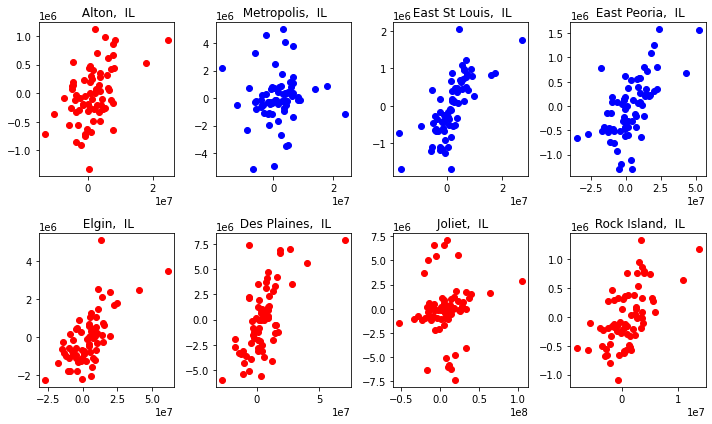

In [46]:
shape = (2,4)
fig, axes = plt.subplots(*shape, figsize=(10,6))

for idx in range(len(casinos)):
    row, column = subplot_map(idx, shape[1])
    casino  = casinos[idx]
    dataframe = differences[differences.casino == casino]
    x = dataframe.amount_played
    y = dataframe.adjusted_gross_receipt
    axes[row, column].scatter(x,y, color='red' if list(y)[-1] > list(y)[0] else 'blue')
    title = casino.split(',')
    title = title[1] + ', ' + title[2][:3]
    axes[row, column].set_title(title)
fig.tight_layout()

In [39]:
vc = {'amount_played_centered': '0 + amount_played_centered'}
model = sm.MixedLM.from_formula('adjusted_gross_receipt ~ amount_played_centered', 
                        vc_formula=vc,
                        groups='casino',
                        data=differences)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
===========================================================================================
Model:                     MixedLM        Dependent Variable:        adjusted_gross_receipt
No. Observations:          567            Method:                    REML                  
No. Groups:                8              Scale:                     2430229783450.1279    
Min. group size:           70             Log-Likelihood:            -8873.3157            
Max. group size:           71             Converged:                 Yes                   
Mean group size:           70.9                                                            
-------------------------------------------------------------------------------------------
                                Coef.        Std.Err.    z    P>|z|    [0.025      0.975]  
-------------------------------------------------------------------------------------------
Intercept                        -19135.295  65468.462 -0.292 0.770 -147451.123  109180.534
amount_played_centered           596838.670 227286.787  2.626 0.009  151364.752 1042312.587
amount_played_centered Var 378493874023.188 142606.711                                     
===========================================================================================

"""

In [41]:
model_autoregressive = sm.GEE.from_formula(
    formula = "adjusted_gross_receipt ~ amount_played_centered",
    groups="casino",
    cov_struct=sm.cov_struct.Autoregressive(), 
    data=differences
    ).fit()

model_autoregressive.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                GEE Regression Results                               
=====================================================================================
Dep. Variable:        adjusted_gross_receipt   No. Observations:                  567
Model:                                   GEE   No. clusters:                        8
Method:                          Generalized   Min. cluster size:                  70
                        Estimating Equations   Max. cluster size:                  71
Family:                             Gaussian   Mean cluster size:                70.9
Dependence structure:         Autoregressive   Num. iterations:                     2
Date:                       Sat, 31 Oct 2020   Scale:               2758338938291.368
Covariance type:                      robust   Time:                         17:20:25
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.914e+04   1.67e+04     -1.147      0.252   -5.18e+04    1.36e+04
amount_played_centered  5.969e+05   2.13e+05      2.803      0.005     1.8e+05    1.01e+06
==============================================================================
Skew:                          0.3777   Kurtosis:                       6.2037
Centered skew:                 0.3534   Centered kurtosis:              6.1352
==============================================================================
"""

In [ ]:
172,485,344,229
596,900

In [183]:
algo = OLS(differences.adjusted_gross_receipt, differences.amount_played)

In [184]:
model = algo.fit()

In [185]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     adjusted_gross_receipt   R-squared (uncentered):                   0.146
Model:                                OLS   Adj. R-squared (uncentered):              0.145
Method:                     Least Squares   F-statistic:                              97.04
Date:                    Mon, 26 Oct 2020   Prob (F-statistic):                    3.08e-21
Time:                            22:40:31   Log-Likelihood:                         -8907.7
No. Observations:                     567   AIC:                                  1.782e+04
Df Residuals:                         566   BIC:                                  1.782e+04
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
amount_played     0.0530      0.005      9.851      0.000       0.042       0.064
==============================================================================
Omnibus:                       86.597   Durbin-Watson:                   3.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.645
Skew:                          -0.051   Prob(JB):                    7.17e-229
Kurtosis:                       9.668   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

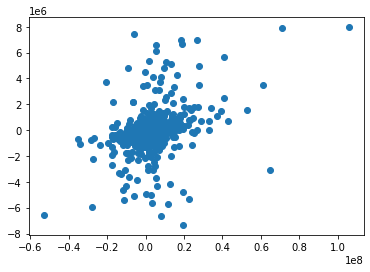

In [186]:
plt.scatter(differences.amount_played, differences.adjusted_gross_receipt)

In [187]:
from sklearn.linear_model import LinearRegression

In [188]:
model = LinearRegression()
model.fit(differences.amount_played.to_numpy().reshape(-1,1), differences.adjusted_gross_receipt.to_numpy().reshape(-1,1))

LinearRegression()

In [189]:
preds = model.predict(differences.amount_played.to_numpy().reshape(-1,1))

In [190]:
from sklearn.metrics import r2_score

In [191]:
r2_score(differences.adjusted_gross_receipt.to_numpy().reshape(-1,1), preds)

0.15584202108358425

In [208]:
monthly_terminal_count = df[['name', 'terminal_count', 'total_population_estimatetotal']].groupby(['name', pd.Grouper(freq='MS')]).sum().reset_index()
monthly_terminal_count[monthly_terminal_count.terminal_count > 100].name.value_counts()

Joliet         72
Rockford       71
Springfield    70
Bloomington    69
Kankakee       67
               ..
Oswego          4
Marion          4
East Moline     3
Sandwich        2
Metropolis      1
Name: name, Length: 91, dtype: int64

In [202]:
monthly_terminal_count[monthly_terminal_count.terminal_count < 50]

terminal_count
name     date                      
Abingdon 2013-01-01            10.0
         2013-02-01            14.0
         2013-03-01            14.0
         2013-04-01            14.0
         2013-05-01            17.0
...                             ...
Zion     2018-08-01            35.0
         2018-09-01            35.0
         2018-10-01            35.0
         2018-11-01            35.0
         2018-12-01            35.0

[47629 rows x 1 columns]

In [193]:
df[['name', 'terminal_count']].groupby(['name', pd.Grouper(freq='MS')]).sum()

terminal_count
name     date                      
Abingdon 2013-01-01            10.0
         2013-02-01            14.0
         2013-03-01            14.0
         2013-04-01            14.0
         2013-05-01            17.0
...                             ...
Zion     2018-08-01            35.0
         2018-09-01            35.0
         2018-10-01            35.0
         2018-11-01            35.0
         2018-12-01            35.0

[57353 rows x 1 columns]

In [194]:
df.columns

Index(['total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing', 'total_wholesale_trade',
       'total_retail_trade',
       'total_transportation_and_warehousing_and_utilities',
       'total_information',
       'total_finance_and_insurance_and_real_estate_and_rental_and_leasing',
       'total_professional_scientific_and_management_and_administrative_and_waste_management_services',
       'total_educational_services_and_health_care_and_social_assistance',
       'total_arts_entertainment_and_recreation_and_accommodation_and_food_services',
       'total_other_services_except_public_administration',
       'total_public_administration',
       'total_management_business_science_and_arts_occupations',
       'total_service_occupations', 'total_sales_and_office_occupations',
       'total_natural_resources_construction_and_maintenance_occupations',
       'total_production_transportation_and_material_moving_occupations',
       'p